# Year 2023 Day 18

[--- Day 18: Lavaduct Lagoon ---](https://adventofcode.com/2023/day/18)

## Motive

Using Observable Plot to visualize the problem.

Note: the Part 2 is solved using the same formulas than Part 1 ; the difference resides in the changed input parsing method.

## Related puzzles

- [Notebook 202310](./notebook_problem_202310.html) (_Pipe Maze_): The goal is also to compute an area inside of a grid ; however no formula is used, only bruteforce with a flood fill algorithm. Possible, using the approach of Day 18, there would be a more efficient way to solve it.


In [1]:
from advent_of_code.common.common import get_example_inputs_file_contents
from advent_of_code.visualization.observable_plot import ObservablePlotXarrayBuilder
from advent_of_code.y_2023.problem_202318 import (
    AdventOfCodeProblem202318,
    parse_text_input_part_1,
    parse_text_input_part_2,
    compute_polygon_coords,
)
import xarray as xr
import numpy as np
import pandas as pd

problem = AdventOfCodeProblem202318()
input_id = "EXAMPLE_INPUT_3_X_3_LOOP"
input_id = "EXAMPLE_INPUT_3_X_4_LOOP"
input_id = "EXAMPLE_INPUT"

example_input = get_example_inputs_file_contents(2023)["test_problem_202318"][input_id]
puzzle_input = parse_text_input_part_1(example_input)
dig_plan = puzzle_input
dig_plan

[DigInstruction(direction=0, meters=6, color='#70c710'),
 DigInstruction(direction=3, meters=5, color='#0dc571'),
 DigInstruction(direction=2, meters=2, color='#5713f0'),
 DigInstruction(direction=3, meters=2, color='#d2c081'),
 DigInstruction(direction=0, meters=2, color='#59c680'),
 DigInstruction(direction=3, meters=2, color='#411b91'),
 DigInstruction(direction=2, meters=5, color='#8ceee2'),
 DigInstruction(direction=1, meters=2, color='#caa173'),
 DigInstruction(direction=2, meters=1, color='#1b58a2'),
 DigInstruction(direction=1, meters=2, color='#caa171'),
 DigInstruction(direction=0, meters=2, color='#7807d2'),
 DigInstruction(direction=1, meters=3, color='#a77fa3'),
 DigInstruction(direction=2, meters=2, color='#015232'),
 DigInstruction(direction=1, meters=2, color='#7a21e3')]

### With Example Input

#### Convert Problem's Input to Visualization Input


In [2]:
polygon_coords = compute_polygon_coords(dig_plan)

# Note: the y, x order is important as the problems follows a row, col convention
xda = xr.DataArray(
    data=polygon_coords, dims=("axis", "point"), coords={"axis": ["y", "x"]}
)
df = xda.T.to_pandas()

df["x2"] = np.roll(df["x"], -1)
df["y2"] = np.roll(df["y"], -1)
df = df.rename(columns={"x": "x1"})
df = df.rename(columns={"y": "y1"})
df = df [["x1", "x2", "y1", "y2"]]

links_df = df[:-1] # remove redundant closing link to declutter the plot
links_df

axis,x1,x2,y1,y2
point,,,,
0,0,6,0,0
1,6,6,0,5
2,6,4,5,5
3,4,4,5,7
4,4,6,7,7
5,6,6,7,9
6,6,1,9,9
7,1,1,9,7
8,1,0,7,7


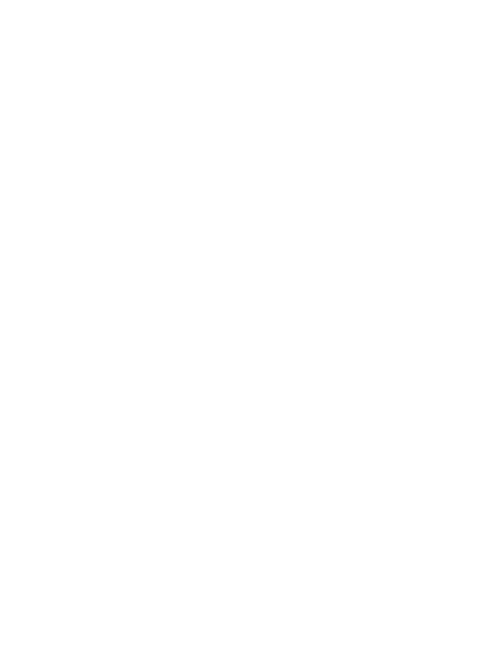

In [3]:
from typing import Any, Callable
from pyobsplot import Plot


def create_background_layer(*, stroke: str = "white") -> Callable[[], list[Any]]:
    def callback() -> list[Any]:
        return [
            Plot.gridX(
                {
                    "interval": 1,
                    "stroke": stroke,
                    "strokeOpacity": 0.5,
                    "strokeWidth": 2,
                }
            ),
            Plot.gridY(
                {
                    "interval": 1,
                    "stroke": stroke,
                    "strokeOpacity": 0.5,
                    "strokeWidth": 2,
                }
            ),
            Plot.frame(),
        ]

    return callback


def create_polygon_layer(
    links_df: pd.DataFrame,
    *,
    color: str = "red",
    stroke_width: int = 2,
    offset: float = 0,
) -> Callable[[], list[Any]]:
    def callback() -> list[Any]:
        x1_target = "x1"
        x2_target = "x2"
        y1_target = "y1"
        y2_target = "y2"

        return [
            Plot.link(  # type:ignore
                links_df + offset,
                {
                    x1_target: "x1",
                    y1_target: "y1",
                    x2_target: "x2",
                    y2_target: "y2",
                    "stroke": color,
                    "strokeWidth": stroke_width,
                    "markerEnd": "arrow",
                },
            )
        ]

    return callback


def create_indicative_dots_layer(
    raster_xda: xr.DataArray, *, radius: int = 100, color: str = "white", opacity: float = 1,
    highlight_origin: bool = False
) -> Callable[[], list[Any]]:
    def callback() -> list[Any]:
        offset = 1
        data = np.zeros(
            (
                raster_xda.shape[0] + offset,
                raster_xda.shape[1] + offset,
            ),
            dtype=int,
        )
        xda_with_borders = xr.DataArray(
            data=data,
            dims=("row", "col"),
            coords=dict(
                row=np.arange(data.shape[0]),
                col=np.arange(data.shape[1]),
            ),
        )
        xda = xda_with_borders
        # Convert a MultiIndex to a DataFrame:
        # See https://pandas.pydata.org/docs/reference/api/pandas.MultiIndex.to_frame.html
        df = xda.stack({"z": ("row", "col")}).to_pandas().index.to_frame()
        marks = [
            Plot.dot(  # type:ignore
                df,
                {"x": "col", "y": "row", "color": color, "opacity":.05,  "r": radius},
            ),
            Plot.dot(  # type:ignore
                df,
                {"x": "col", "y": "row", "color": color, "opacity":opacity,  "r": radius // 4},
            ),
            Plot.dot(  # type:ignore
                df,
                {"x": "col", "y": "row", "color": color, "opacity":opacity,  "r": radius, "symbol":"square"},
            ),]
        if highlight_origin: 
            new_marks =[
            # Origin at (0, 0)
            Plot.dot(  # type:ignore
                [(0, 0)], {"stroke": "#0f0", "r": radius}
            ),
            # Origin at (0, 0)
            Plot.dot(  # type:ignore
                [(0, 0)], {"stroke": "#0f0", "r": radius // 4}
            ),
        ]   
            
            marks.extend(new_marks)
        return marks

    return callback


pixel_width = scale = 60
raster_xda = xr.DataArray(
    data=np.zeros(xda.max(dim="point").values, dtype=int), dims=("row", "col")
)
# Create an alterning pattern
# 0 1
# 1 0
raster_xda[:, :] = 1
raster_xda[::2, ::2] = 0
raster_xda[1::2, 1::2] = 0

margin = 40
raster_width = raster_xda["col"].size
raster_height = raster_xda["row"].size
x_domain = [0 - 1, raster_width + 1]
y_domain = [0 - 1, raster_height + 1]
y_domain = list(reversed(y_domain))

kwargs = dict(
    color={"range": ["#111", "#222"]},
    width=(raster_xda["col"].size + 2) * scale,
    height=(raster_xda["row"].size + 2) * scale,
    marginLeft=margin,
    marginRight=margin,
    marginTop=margin,
    marginBottom=margin,
    # ascending_y_axis=False,
)
# kwargs.update({"x": {"domain": x_domain}, "y": {"domain": y_domain}})


plotter = ObservablePlotXarrayBuilder(raster_xda=raster_xda, initial_kwargs=kwargs)
# plotter.append(create_background_layer())
plotter.append(create_indicative_dots_layer(raster_xda, radius=pixel_width//2, opacity = .3, highlight_origin = False))
plotter.append(create_polygon_layer(links_df, color="red", stroke_width=4))
plotter.plot()

##### Highlight _boundary points_


In [4]:
links_df

axis,x1,x2,y1,y2
point,,,,
0,0,6,0,0
1,6,6,0,5
2,6,4,5,5
3,4,4,5,7
4,4,6,7,7
5,6,6,7,9
6,6,1,9,9
7,1,1,9,7
8,1,0,7,7


In [5]:
def compute_boundary_points_coords(links_df: pd.DataFrame):
    points = []

    for r in links_df.iterrows():
        _, data = r
        dx = data["x2"] - data["x1"]
        dy = data["y2"] - data["y1"]
        # print(data.to_list(), dx, dy)

        if dx != 0:
            arr = np.linspace(1, np.abs(dx), num=np.abs(dx), dtype=int)
            if dx < 0:
                arr = -arr
            for x in (data["x1"] + arr.reshape(-1, 1)).reshape(-1):
                points.append((x, data["y1"], "#f0f"))

        if dy != 0:
            arr = np.linspace(1, np.abs(dy), num=np.abs(dy), dtype=int)
            if dy < 0:
                arr = -arr
            for y in (data["y1"] + arr.reshape(-1, 1)).reshape(-1):
                points.append((data["x1"], y, "#0ff"))

    return pd.DataFrame(points, columns=["x", "y", "stroke"])


boundary_points_coords = compute_boundary_points_coords(links_df)
boundary_points_coords

,x,y,stroke
0,1,0,#f0f
1,2,0,#f0f
2,3,0,#f0f
3,4,0,#f0f
4,5,0,#f0f
5,6,0,#f0f
6,6,1,#0ff
7,6,2,#0ff
8,6,3,#0ff
9,6,4,#0ff


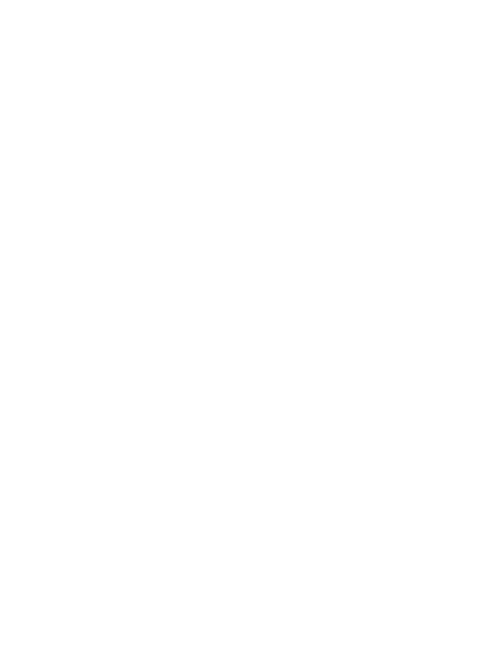

In [6]:
def create_boundary_points_layer(
    boundary_points_coords: pd.DataFrame, **kwargs: Any
) -> Callable[[], list[Any]]:
    def callback() -> list[Any]:
        marks = [
            Plot.dot(  # type:ignore
                boundary_points_coords,
                {"x": "x", "y": "y", "stroke": "stroke", **kwargs},
            ),
        ]
        return marks

    return callback


plotter.copy(raster_xda=raster_xda).append(
    create_boundary_points_layer(
        boundary_points_coords,
        stroke="#a00",
        strokeWidth=4,
        r=pixel_width // 2,
        opacity=1,
        symbol="square",
    )
).plot()



In the plot below, crossed cells are colored with a different stroke whether they result from a vertical or horizontal move.

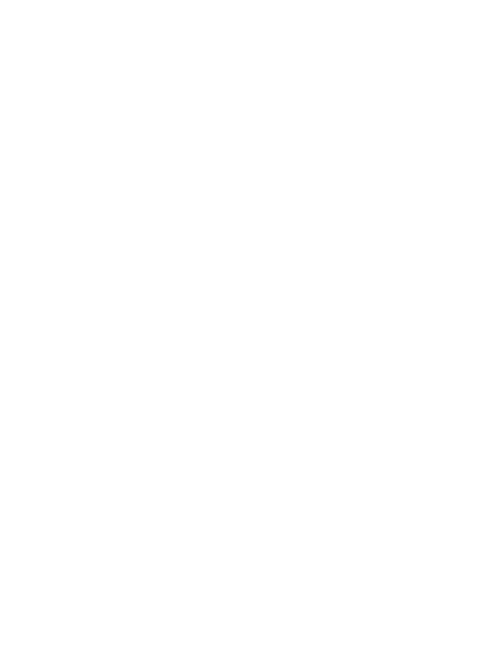

In [7]:
plotter.copy(raster_xda=raster_xda).append(
    create_boundary_points_layer(
        boundary_points_coords,
        r=pixel_width // 2,
        opacity=1,
        symbol="square",
    )
).plot()

For visualization purposes of the interior points, a flood fill algorithm is used, as in the problem 202310. However, the flood fill algorithm is not required to solve the problem.

In [8]:
from advent_of_code.common.common import render_2d_data_array


contour = raster_xda.copy(deep=True)
contour[:, :] = 0
contour = contour.pad(dict(row=(0, 1), col=(0, 1)), constant_values=0)
for row in boundary_points_coords.iterrows():
    _, data = row
    x, y, color = data
    contour[y, x] = 1
contour

<xarray.DataArray (row: 10, col: 7)>
array([[1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1],
       [1, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 1, 1]])
Dimensions without coordinates: row, col

In [9]:
from skimage.morphology import flood_fill  # pyright: ignore[reportUnknownVariableType]


filled = contour.copy(data=flood_fill(contour.values, (1, 1), 2))
filled

<xarray.DataArray (row: 10, col: 7)>
array([[1, 1, 1, 1, 1, 1, 1],
       [1, 2, 2, 2, 2, 2, 1],
       [1, 1, 1, 2, 2, 2, 1],
       [0, 0, 1, 2, 2, 2, 1],
       [0, 0, 1, 2, 2, 2, 1],
       [1, 1, 1, 2, 1, 1, 1],
       [1, 2, 2, 2, 1, 0, 0],
       [1, 1, 2, 2, 1, 1, 1],
       [0, 1, 2, 2, 2, 2, 1],
       [0, 1, 1, 1, 1, 1, 1]])
Dimensions without coordinates: row, col

In [10]:
filled_df = pd.DataFrame(filled.stack(z=("row", "col")).to_pandas(), columns=["type"])
mapping = {0: "black", 1: "#a00", 2: "#0aa"}
filled_df["stroke"] = filled_df["type"].map(lambda x: mapping[x])
filled_df

type stroke
row col             
0   0       1   #a00
    1       1   #a00
    2       1   #a00
    3       1   #a00
    4       1   #a00
...       ...    ...
9   2       1   #a00
    3       1   #a00
    4       1   #a00
    5       1   #a00
    6       1   #a00

[70 rows x 2 columns]

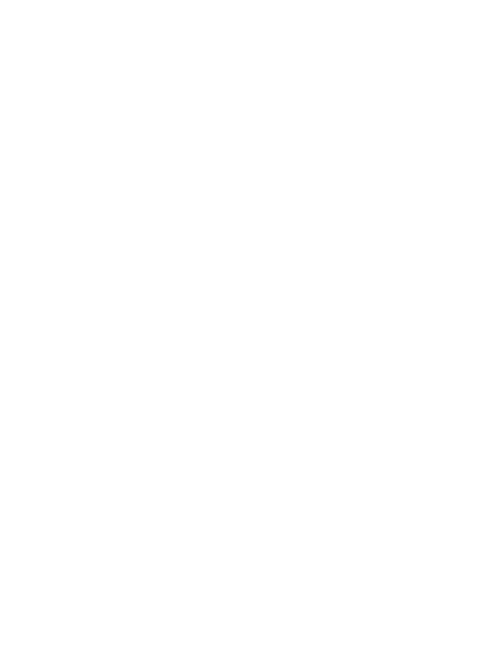

In [11]:
def create_boundary_and_interior_points_layer(
    filled_df: pd.DataFrame, **kwargs: Any
) -> Callable[[], list[Any]]:
    def callback() -> list[Any]:
        marks = [
            Plot.dot(  # type:ignore
                filled_df,
                {"x": "col", "y": "row", "stroke": {"value": "stroke"
                                                    }, **kwargs},
            ),
        ]
        return marks

    return callback


plotter.copy(raster_xda=raster_xda).append(
    create_boundary_and_interior_points_layer(
        filled_df,
        strokeWidth=4,
        r=pixel_width // 2,
        opacity=1,
        symbol="square",
    )
).plot()



The internal area of the polygon represented by the red arrows can be computed via the shoelace formula. It is the path followed by the miner. It is noted in the following formulas as $A$.

The amount of _boundary points_ is represented by the dark red squares that the red arrows cross. It is the initial space dug by the miner. It is noted in the following formulas as $b$.

The amount of _interior points_ is represented by te dark cyan squares. It is noted bn the following formulas as $b$.

The total area dug by the minor is made of the cyan and red cells: $area = i + b$. 

#### Math

The area of the polygon can be found using the [shoelace formula](https://en.wikipedia.org/wiki/Shoelace_formula).

$$
A = \frac 1 2 \sum_{i=1}^n (y_i + y_{i+1})(x_i - x_{i+1})
$$

_This formula is used in the `compute_shoelace_formula` function_

However, this is not enough to complete the problem. Indeed, this internal area does not take into account the borders. We want to know the total amount of cells that are dug.

This is where the [Pick's theorem](https://en.wikipedia.org/wiki/Pick%27s_theorem) intervenes:

$$
A = i + \frac{b}{2} - 1
$$



where $A$ is the area of the polygon, $i$ is is the number of points with integer coordinates inside of the polygon, and $b$ is the number of points with integer coordinates on its boundary.

_This formula is used in the `compute_pick_polygon_area_formula` function_

$A$ is known as the polygon's area computed from the shoelace formula. $b$ happens to be equal to the perimeter of the polygon. To compute it, sum all the numbers of meters to dig given in the puzzle input.

The amount of dug cells is given by $i + b$: the interior points and boundary points are both considered to compute it. Then we have:

$$
\begin{aligned}
area 
&= i + b \\
&= (A - \frac{b}{2} + 1) + b \\
&= A + \frac{b}{2} + 1 \\
\end{aligned}
$$


Note that the Pick's formula can be used without any change by cleverly choosing the arguments passed to it. Indeed:


$$
\begin{aligned}
Pick(i=A, b=perimeter + 4) 
&= i + \frac{b}{2} - 1 \\
&= A + \frac{perimeter + 4}{2} - 1 \\
&= A + \frac{b}{2} + 1 \\
&= area
\end{aligned}
$$

It means the problem can be solved by composing the functions implementing the Pick's formula and the shoelace formula.